# Benchmark: Linear Learner

In this notebook we will train a linear learner to forecast cryptocurrency price values. This model will be used as benchamrk to be compared with the DeepAR model.

The steps followed are:
* Create the dataset
* Train the model
* Deploy the model
* Evaluate the model's performance on the test set

## Imports and utilities

In [38]:
from os import listdir
from os.path import isfile, join
import io

import pandas as pd
import numpy as np

import boto3

import sagemaker
from sagemaker import get_execution_role
from sagemaker import LinearLearner
import sagemaker.amazon.common as smac
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [3]:
print("Pandas version:", pd.__version__)
print("Sagemaker version:", sagemaker.__version__)

Pandas version: 1.1.5
Sagemaker version: 2.29.2


In [40]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = 'crypto-forecasting/linear-learner'

We will define a function to load the wanted CSV file

In [5]:
def load_csv_file(file_name, data_path="data/raw", date_col="Date"):
    """
    Loads a CSV file into a dataframe with datetime index.
    :param file_name: the name of the CSV file
    :data_path: the direcotry where the file is stored
    :date_col: the column to be used as datetime index
    """
    data_file = join(data_path, file_name)
    df = pd.read_csv(data_file)
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [6]:
bitcoin_data = load_csv_file("coin_Bitcoin.csv")

## Create Linear Learner dataset

For the linear learner model that will be used as benchmark, we will create some featues. The features created will be created taking into account what the DeepAR model [automatically](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html#deepar_under-the-hood) does.

* Feature time series: day-of-week, day-of-month, day-of-year
* Lagged values: 1,2 and 3 weeks 

In [7]:
def make_linar_learner_features(df, target="Close"):
    """
    Generates feature time series and lagged values for the linear learner dataset.
    The missing lag values will be filled with 0s.
    :param df: the input dataframe with datetime index
    :param target: the target column
    :return: the input dataframe with the new created features
    """
    
    # Featuer time series
    df["day_of_week"] = df.index.dayofweek
    df["day_of_month"] = df.index.day
    df["day_of_year"] = df.index.dayofyear
    
    # Lagged values
    df["lag_1_week"] = df[target].shift(periods=7*1, fill_value=0)
    df["lag_2_week"] = df[target].shift(periods=7*2, fill_value=0)
    df["lag_3_week"] = df[target].shift(periods=7*3, fill_value=0)
    
    return df[[target, "day_of_week", "day_of_month", "day_of_year", "lag_1_week", "lag_2_week", "lag_3_week"]]
    

Let's create the features for the Linear Learner (ll)

In [8]:
bitcoin_ll = make_linar_learner_features(bitcoin_data)

In [9]:
bitcoin_ll.head(10)

,Close,day_of_week,day_of_month,day_of_year,lag_1_week,lag_2_week,lag_3_week
Date,,,,,,,
2013-04-29 23:59:59,144.539993,0,29,119,0.000000,0.0,0.0
2013-04-30 23:59:59,139.000000,1,30,120,0.000000,0.0,0.0
2013-05-01 23:59:59,116.989998,2,1,121,0.000000,0.0,0.0
2013-05-02 23:59:59,105.209999,3,2,122,0.000000,0.0,0.0
2013-05-03 23:59:59,97.750000,4,3,123,0.000000,0.0,0.0
2013-05-04 23:59:59,112.500000,5,4,124,0.000000,0.0,0.0
2013-05-05 23:59:59,115.910004,6,5,125,0.000000,0.0,0.0
2013-05-06 23:59:59,112.300003,0,6,126,144.539993,0.0,0.0
2013-05-07 23:59:59,111.500000,1,7,127,139.000000,0.0,0.0


Now we will split the target from the features and we will split the data to train and test sets.

Since this is time series data, we will use the first 60% for training, the next 20% for validation and the last 20% for testing.

In [12]:
split_train = int(len(bitcoin_ll) * 0.6)
split_test = int(len(bitcoin_ll) * 0.8)

target = "Close"

train_y = bitcoin_ll[target][:split_train].to_numpy()
train_X = bitcoin_ll.drop(target, axis=1).iloc[:split_train, ].to_numpy()

val_y = bitcoin_ll[target][split_train:split_test].to_numpy()
val_X = bitcoin_ll.drop(target, axis=1).iloc[split_train:split_test, ].to_numpy()

test_y = bitcoin_ll[target][split_test:].to_numpy()
test_X = bitcoin_ll.drop(target, axis=1).iloc[split_test:, ].to_numpy()

print("Training samples:", len(train_y))
print("Validation samples:", len(val_y))
print("Test samples:", len(test_y))

Training samples: 1717
Validation samples: 572
Test samples: 573


### Upload data to S3

Next, the data is prepared for the linear learner model by converting the datasets to the recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms and upload this data to S3. 

Training data

In [48]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_X.astype('float32'), train_y.astype('float32'))
buf.seek(0)

0

In [49]:
key = join(prefix, 'train', 'linear_train.data')
boto3.resource('s3').Bucket(bucket).Object(key).upload_fileobj(buf)
s3_train_data = 's3://{}/{}'.format(bucket, key)
print('Uploaded training data location: {}'.format(s3_train_data))

Uploaded training data location: s3://sagemaker-us-east-1-034143355118/crypto-forecasting/linear-learner/train/linear_train.data


Validation data

In [50]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, val_X.astype('float32'), val_y.astype('float32'))
buf.seek(0)

0

In [51]:
key = join(prefix, 'validation', 'linear_validation.data')
boto3.resource('s3').Bucket(bucket).Object(key).upload_fileobj(buf)
s3_validation_data = 's3://{}/{}'.format(bucket, key)
print('Uploaded validation data location: {}'.format(s3_validation_data))

Uploaded validation data location: s3://sagemaker-us-east-1-034143355118/crypto-forecasting/linear-learner/validation/linear_validation.data


## Create a LinearLearner Estimator¶

We will use the built in [linear learner](https://sagemaker.readthedocs.io/en/stable/algorithms/linear_learner.html) estimator.

In [47]:
output_path = 's3://{}/{}/model-artifacts'.format(bucket, prefix)

container = sagemaker.image_uris.retrieve('linear-learner', sagemaker_session.boto_region_name)

linear = sagemaker.estimator.Estimator(container,
                                       role=role,
                                       instance_count=1, 
                                       instance_type='ml.c4.xlarge',
                                       predictor_type='regressor',
                                       output_path=output_path,
                                       sagemaker_session=sagemaker_session
                                       )

linear.set_hyperparameters(feature_dim=6,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=100,
                           num_models=32,
                           early_stopping_patience=10)

### Train the estimator

In [52]:
%%time

linear.fit({"train": s3_train_data, "validation": s3_validation_data})

2021-03-22 21:09:15 Starting - Starting the training job...
2021-03-22 21:09:39 Starting - Launching requested ML instancesProfilerReport-1616447355: InProgress
.........
2021-03-22 21:10:59 Starting - Preparing the instances for training.........
2021-03-22 21:12:39 Downloading - Downloading input data......
2021-03-22 21:13:40 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/22/2021 21:13:46 INFO 140350886659904] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', '

### Deploy the estimator

Now that we've trained the linear algorithm on our data, let's create a model and deploy that to a hosted endpoint.

In [53]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

In [56]:
linear_predictor.serializer = CSVSerializer() 
linear_predictor.deserializer = JSONDeserializer()

## Evaluation

For evaluating the model we will use the Root Mean Square Error (RMSE) on the predictions done on the test set.

To generate the forecast, we wil use a One-step-ahead forecasts aproach. When predicting for multiple data points, one-step-ahead forecasts update the history with the correct known value. These are common, easy to produce, and can give us some intuition of whether our model is performing as expected. However, they can also present an unnecessarily optimistic evaluation of the forecast. In most real-life cases, we want to predict out well into the future, because the actions we may take based on that forecast are not immediate.

In [63]:
index = 100

sample = test_X[index].astype('float32')
target = test_y[index]

prediction = linear_predictor.predict(sample)

print("Target\n", target)
print("Sample\n", sample)
print("Prediction\n", prediction)

Target
 8808.2625823
Sample
 [2.000000e+00 1.300000e+01 3.170000e+02 9.360880e+03 9.205727e+03
 7.514672e+03]
Prediction
 {'predictions': [{'score': 8501.8232421875}]}


Now we invoke the endpoint with all the testing data.

In [58]:
result = linear_predictor.predict(test_X.astype('float32'))

In [60]:
one_step = np.array([r['score'] for r in result["predictions"]])

One-step-ahead RMSE =  2948.7851200624755


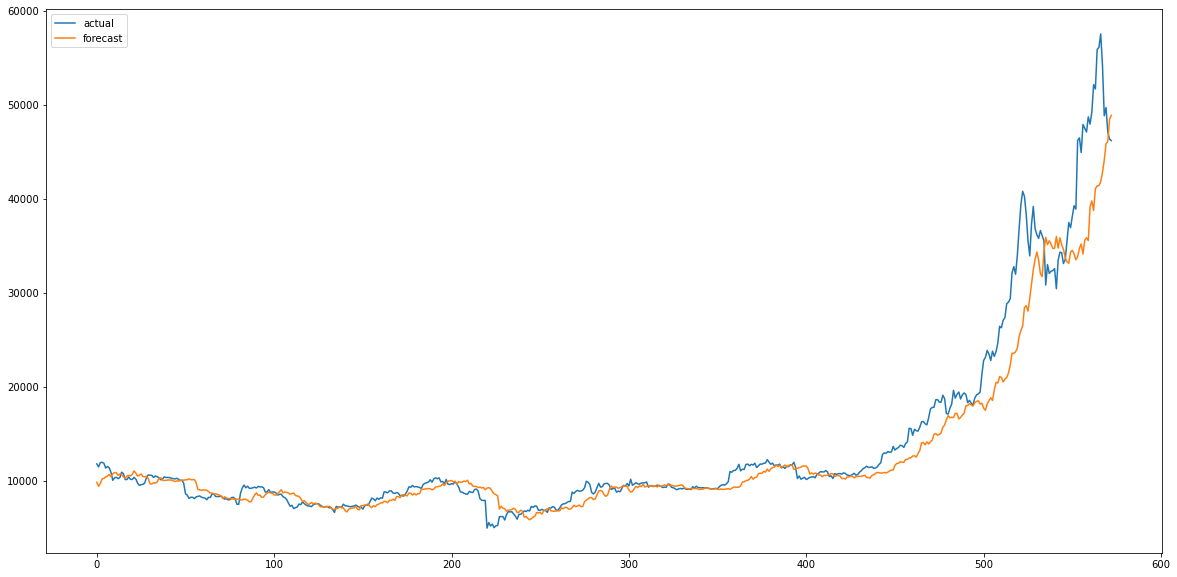

In [66]:
print('One-step-ahead RMSE = ', np.sqrt(mean_squared_error(test_y, one_step)))
plt.figure(figsize=(20,10))
plt.plot(test_y, label='actual')
plt.plot(one_step, label='forecast')
plt.legend()
plt.show()

## Clean up

In [64]:
linear_predictor.delete_endpoint()